In [14]:
import numpy as np 
import os
from glob import glob
from astropy.io import fits
from tqdm import tqdm
import matplotlib.pyplot as plt
import statistics
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from numpy.polynomial import Legendre, Chebyshev


In [3]:
with open('user_input.txt', 'r') as file:
    lines = file.readlines()

path = lines[0].strip()
mflat = os.path.join(path, 'mflat.fits')
data = fits.open(mflat)[0].data
header = fits.open(mflat)[0].header
xpixels = header['NAXIS1']
ypixels = header['NAXIS2']


normalised_data = np.mean(data, axis=1)

In [4]:
pixels = np.arange(0,ypixels,1)

<Figure size 504x504 with 0 Axes>

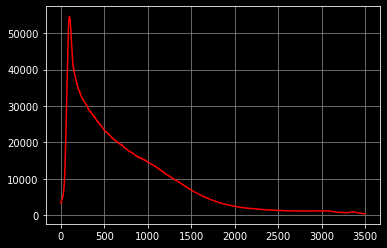

In [36]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
# Plot some data

# Set borders (spines)
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

# Erase the grid
ax.grid(True, color='grey')

plt.plot(pixels, normalised_data, c ='red')


In [30]:
parameters = {
        "naverage": 2,
        "function": "spline",
        "order": 2,
        "lreject": 3.0,
        "hreject": 3.0,
        "iter": 5
    }

naverage = parameters['naverage']
function = parameters['function']
order = parameters['order']
lreject = parameters['lreject']
hreject = parameters['hreject']
iter = parameters['iter']


In [33]:
def spline(x, y, order):
    s = UnivariateSpline(x, y, k=order)
    return s(x)
def legendre(x, y, order):
    l = Legendre.fit(x, y, order)
    return l(x)

def chebyshev(x, y, order):
    c = Chebyshev.fit(x, y, order)
    return c(x)

function_map = {
    'spline': spline,
    'legendre': legendre,
    'chebyshev': chebyshev
}


In [34]:
normalised_data = np.mean(data, axis=1)
normalised_data = np.mean(data, axis=1)
pixels = np.arange(0,ypixels,1)
sample_points = []
for i in range(0,len(normalised_data),abs(int(naverage))):
    while True:
        if naverage > 0:
            sample_points.append(np.mean(normalised_data[i:i+int(naverage)]))
            break
        elif naverage < 0 :
            sample_points.append(statistics.median(normalised_data[i:i+abs(int(naverage))]))
            break
        else :
            print("Enter either a positive or negative number")
            naverage = input("naverage: ")
            continue
sample_pixels = np.arange(0,ypixels,abs(int(naverage)))
popt, pcov = curve_fit(spline, sample_pixels, sample_points)

    

ValueError: x and y should have a same length

In [35]:
x

NameError: name 'x' is not defined

In [2]:
parameters = {
        "naverage": 1,
        "function": "spline1",
        "order": 2,
        "lreject": 3.0,
        "hreject": 3.0,
        "iter": 5
    }
function_options = ["spline1", "spline3", "chebyshev", "legendre"]

print("Please enter the values for the parameters you want (default values are shown):")
while True:
    for param, default in parameters.items():
        print(f"{param} (default: {default})")
    param = input("Enter the parameter you want to input (or 'done' to finish): ")
    if param.lower() == 'done':
        break
    if param in parameters:
        value = input(f"{param} (default: {parameters[param]}): ")
        if param == 'function':
            # Check if the input is one of the four options
            if value in function_options:
                parameters[param] = value
            else:
                print("Invalid input. 'function' parameter should be one of the following: " + ", ".join(function_options))
        else:
            # Check if the input can be converted to a number
            try:
                value = float(value)
                parameters[param] = value
            except ValueError:
                print("Invalid input. This parameter should be a number.")
    else:
        print("Invalid parameter. Please try again.")


Please enter the values for the parameters you want (default values are shown):
naverage (default: 1)
function (default: spline1)
order (default: 2)
lreject (default: 3.0)
hreject (default: 3.0)
iter (default: 5)
Invalid input. 'function' parameter should be one of the following: spline1, spline3, chebyshev, legendre
naverage (default: 1)
function (default: spline1)
order (default: 2)
lreject (default: 3.0)
hreject (default: 3.0)
iter (default: 5)
Invalid input. 'function' parameter should be one of the following: spline1, spline3, chebyshev, legendre
naverage (default: 1)
function (default: spline1)
order (default: 2)
lreject (default: 3.0)
hreject (default: 3.0)
iter (default: 5)
Invalid parameter. Please try again.
naverage (default: 1)
function (default: spline1)
order (default: 2)
lreject (default: 3.0)
hreject (default: 3.0)
iter (default: 5)
Invalid parameter. Please try again.
naverage (default: 1)
function (default: spline1)
order (default: 2)
lreject (default: 3.0)
hreject (d

In [4]:
parameters

{'naverage': 1,
 'function': 'spline1',
 'order': 2,
 'lreject': 3.0,
 'hreject': 3.0,
 'iter': 5}

In [6]:
naverage = parameters['naverage']
naverage

1